# Patient Analysis by Age

This notebook explores the `database/metadata.csv` file and generates a patient count by age.

- Reads the CSV and shows an initial summary (rows, columns, sample).
- Converts the `AGE` column to numeric and handles missing values.
- Deduplicates by `SUBJECT_ID` (uses the median age per subject).
- Calculates the patient count by age.
- Displays sorted table and visualizations (histogram and bar chart).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

DATA_PATH = '../../../database/metadata.csv'

In [2]:
# Read CSV
df = pd.read_csv(DATA_PATH)
df.shape, list(df.columns)[:10]

((8971, 20),
 ['SUBJECT_ID',
  'SESSION_ID',
  'CLASS_LABEL',
  'CLASS_LABEL_DETAILED',
  'SEX',
  'AGE',
  'HEIGHT',
  'BODY_WEIGHT',
  'BODY_MASS',
  'SHOE_SIZE'])

In [3]:
# Sample of first rows
df.head()

,SUBJECT_ID,SESSION_ID,CLASS_LABEL,CLASS_LABEL_DETAILED,SEX,AGE,HEIGHT,BODY_WEIGHT,BODY_MASS,SHOE_SIZE,AFFECTED_SIDE,SHOD_CONDITION,ORTHOPEDIC_INSOLE,SPEED,READMISSION,SESSION_TYPE,SESSION_DATE,TRAIN,TRAIN_BALANCED,TEST
0,1,29885,HC,HC,1,18,173.0,516.1,52.6,42.0,NaN,1,0.0,2,0,1,29.01.2015,0,0,1
1,1,29886,HC,HC,1,18,173.0,516.2,52.6,42.0,NaN,1,0.0,1,0,1,29.01.2015,0,0,1
2,1,29888,HC,HC,1,18,173.0,516.1,52.6,42.0,NaN,1,0.0,3,0,1,29.01.2015,0,0,1
3,2,888812549,HC,HC,1,51,182.0,752.1,76.7,44.0,NaN,1,0.0,1,0,1,03.08.2017,1,0,0
4,2,888812550,HC,HC,1,51,182.0,752.4,76.7,44.0,NaN,1,0.0,3,0,1,03.08.2017,1,0,0


## Cleaning and preparing the age column

In [4]:
# Convert AGE to numeric and remove impossible/missing values
df['AGE'] = pd.to_numeric(df['AGE'], errors='coerce')
# Remove negative ages or very unlikely ones (like >120)
df.loc[(df['AGE'] < 0) | (df['AGE'] > 120), 'AGE'] = np.nan
df_age = df.dropna(subset=['AGE']).copy()
df_age['AGE'] = df_age['AGE'].astype(int)
df_age[['SUBJECT_ID','AGE']].head()

,SUBJECT_ID,AGE
0,1,18
1,1,18
2,1,18
3,2,51
4,2,51


## One age per patient (deduplication)

Generally there are multiple sessions per patient. To have one age per patient, we aggregate by `SUBJECT_ID` and use the median of the age recorded in sessions of the same subject.

In [5]:
age_by_subject = (
    df_age.groupby('SUBJECT_ID', as_index=False)['AGE'].median()
)
age_by_subject.rename(columns={'AGE': 'AGE_SUBJECT'}, inplace=True)
age_by_subject.sort_values('AGE_SUBJECT').head()

,SUBJECT_ID,AGE_SUBJECT
1215,1262,9.0
1799,1879,14.0
816,844,14.0
1028,1063,14.0
1024,1059,15.0


## Distribution: number of patients by age

In [6]:
patients_per_age = (
    age_by_subject.groupby('AGE_SUBJECT')
    .size()
    .reset_index(name='NUM_PACIENTES')
)
patients_per_age = patients_per_age.sort_values('AGE_SUBJECT').reset_index(drop=True)
patients_per_age.head()
patients_per_age['AGE_SUBJECT'].max()

80.0

In [7]:
# Quick statistics
total_pacientes = len(age_by_subject)
idade_min = int(age_by_subject['AGE_SUBJECT'].min())
idade_max = int(age_by_subject['AGE_SUBJECT'].max())
idade_mediana = int(age_by_subject['AGE_SUBJECT'].median())
total_pacientes, idade_min, idade_max, idade_mediana

(2295, 9, 80, 43)

## Visualizations

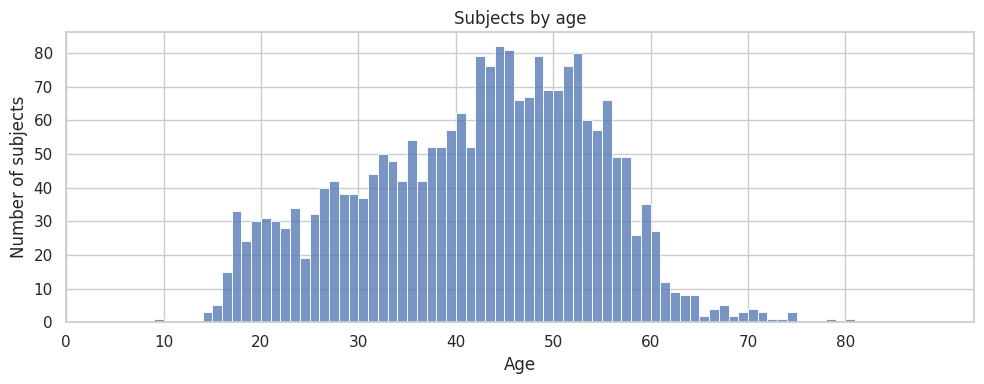

In [8]:

plt.figure(figsize=(10, 4))
sns.histplot(age_by_subject['AGE_SUBJECT'], bins=range(5, 90, 1), kde=False)

plt.title('Subjects by age')
plt.xlabel('Age')
plt.ylabel('Number of subjects')

# Define os ticks do eixo X de 10 em 10
plt.xticks(range(0, 90, 10))

plt.tight_layout()
plt.show()